<a href="https://colab.research.google.com/github/tylerwilliams1010/WUTANG/blob/main/Copy_of_WUTANG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **W**indowed **U**ID actions **T**-Test for **A**nomaly detection from **N**ominal **G**roups

## *What happens when you rely on density-based methods to detect your adversaries?*
## *The adversary learns how to trick the model to provide dense coverage in the region they attack.*

## So, how do we go about detecting a skilled group moving together in silence? 
## Recognize them as the outliers they are.


---


#  ***~ WUTANG ~***



---



# "Choose the sword, and you will join me..."



In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import scipy
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

#Make Dataset
centers = [[0,0], [-1, -1], [1, -1], [0,0.5], [0.4,0.1], [1.5,2], [2,2], [7,6]]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=0.7,
                            random_state=42)
#X = np.vstack([X,[0,2.8]])

# Make nominal groups
dfblobs_baseline = pd.DataFrame(X)
dfblobs_baseline["bad"] = 0

# Make Adversarial examples 
X, labels_true = make_blobs(n_samples=30, centers=centers, cluster_std=0.5,
                            random_state=42)
dfbadblobs_baseline = pd.DataFrame(X)
dfbadblobs_baseline["bad"] = 1

# Combine for baseline
dfblobs_baseline= dfblobs_baseline.append(dfbadblobs_baseline)
dfblobs_baseline = dfblobs_baseline.reset_index()
dfblobs_baseline["uid"] = dfblobs_baseline.index
dfblobs_baseline = dfblobs_baseline.drop(["index"], axis=1)

In [ ]:
# Add noise to nominal groups
dfblobs_adjusted = dfblobs_baseline.loc[dfblobs_baseline["bad"]==0]
dfblobs_adjusted[0] = dfblobs_adjusted[0].apply(lambda x: x + np.random.normal(0, 0.1, 1)[0])

# Add Adversarial Noise to Adversarial Groups
dfbadblobs_adjusted = dfblobs_baseline.loc[dfblobs_baseline["bad"]==1]
dfbadblobs_adjusted[0] = dfbadblobs_adjusted[0].apply(lambda x: x + abs(np.random.normal(0.5, 3.8, 1))[0])

# Combine for adjusted
dfblobs_adjusted= dfblobs_adjusted.append(dfbadblobs_adjusted)
dfblobs_adjusted = dfblobs_adjusted.reset_index()
dfblobs_adjusted["uid"] = dfblobs_adjusted.index
dfblobs_adjusted = dfblobs_adjusted.drop(["index"], axis=1)

# Calculate distance vector for dimension
# *** Comment these out before running, this is just for testing ***
#dfblobs_adjusted["distance"] = dfblobs_adjusted["x"] - dfblobs_adjusted[0]
#dfblobs_adjusted["distance"].apply(lambda x: max(0, x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
dfblobs_baseline = dfblobs_baseline.rename(columns={0: "v1", 1: "v2"})
dfblobs_adjusted = dfblobs_adjusted.rename(columns={0: "v1", 1: "v2"})

In [ ]:
dfblobs_adjusted.groupby("bad").describe()

v1                                ...      uid                         
      count      mean       std       min  ...      25%     50%      75%     max
bad                                        ...                                  
0    1000.0  1.391732  2.379799 -3.228953  ...   249.75   499.5   749.25   999.0
1      30.0  5.055142  3.849899 -0.615853  ...  1007.25  1014.5  1021.75  1029.0

[2 rows x 24 columns]

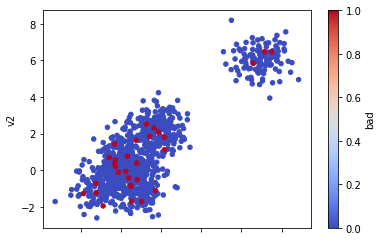

In [ ]:
# Print Core/Baseline Data - Movers in Red
dfblobs_baseline.plot.scatter(x="v1", y="v2", c="bad", colormap="coolwarm")

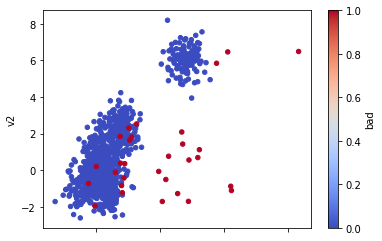

In [ ]:
# Print Adjusted Data - Movers in Red
# Note that the red dots moved right
# Some have moved clearly outside of clusters, but a few remain deep in the base clusters

dfblobs_adjusted.plot.scatter(x="v1", y="v2", c="bad", colormap="coolwarm")

In [ ]:
# Take 2 df's, 1 old 1 new, alpha, uid field, and specify mininmum points
def WUTANG(uidField: str, featureVectors: list, old_df: pd.DataFrame, new_df: pd.DataFrame, alpha: float = 0.01, minPts: int = 5):
    

  #Get dataframes with columns and UIDf_df
    cols = [x for x in featureVectors]
    cols.append(uidField)
    new_df = new_df[cols]
    old_df = old_df[cols]

    # create results_df
    results_df = pd.DataFrame(columns=cols)
    
    # calculate KNN variable where k is 5 >= sqrt(N) <= 50 deduped by uid
    k = min(max(int(len(new_df[uidField].unique()) ** 0.5),5),50)
    numberOfRows = len(new_df.index)

    # left join df on uid field and append cols with '_old'
    diff_df = new_df.join(old_df.set_index(uidField), on=uidField, rsuffix='_old')

    # Calculate diff for each feature to have core diff_df which will later filter out sample k-Nearest Neighbors
    for vector in featureVectors:
        colName = str(vector) + "Diff"
        oldColName = str(vector) + "_old"
        diff_df[colName] = diff_df[vector] - diff_df[oldColName]
        diff_df[colName] = diff_df[colName].apply(lambda x: max(0, x))


    temp_df = pd.DataFrame()
    for x in range(numberOfRows):
    # Identify current UID Value
        iterUID: np.array
        iterUID = new_df.loc[x][featureVectors].reset_index(drop=True).to_numpy().reshape(1,-1)
        xUID = new_df.loc[x]["uid"]
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors.fit(new_df[featureVectors].to_numpy())
        ind = neighbors.kneighbors(iterUID, return_distance=False)
        iterdf = diff_df[diff_df[uidField].isin(ind[0])].drop(labels="uid",axis=1)
        # create filtered primary df by removing k-Nearest Neighbors
        diff_df_filtered = diff_df[-diff_df[uidField].isin(ind[0])].drop(labels="uid",axis=1)


        resultsDict = {}
            
        for vector in featureVectors:
          vectorString = vector+"Diff"
          if iterdf[vectorString].std()==0 and iterdf[vectorString].mean()==0:
            # In the case of sample standard deviation AND mean equal to 0, set val to 0
            val = 0

          elif iterdf[vectorString].std()==0:
            # In the rare case of samples with zero variance, replace sample standard deviation with 1/k
            val = (iterdf[vectorString].mean() - diff_df_filtered[vectorString].mean()) / (1/k**1.5) / (iterdf[colString].mean()) 
  
          else:

            val = (iterdf[vectorString].mean() - diff_df_filtered[vectorString].mean()) / (iterdf[vectorString].std() / (k**0.5))

          # Calculate inverse of t-stat cdf to generate the weighted risk score for ranking
          riskScore = 1/((1-t.cdf(val, (k-1))))


          resultsDict = {"uid":xUID,"feature":vector,"riskScore":riskScore}
            
          temp_df = temp_df.append(resultsDict, ignore_index=True)

    # for each column in temp_df, filter where riskScore > 1/alpha and count length, if length > minPts, add to return_df
    outliers_df = temp_df.loc[temp_df["riskScore"]>=(1/alpha)]
    print(outliers_df)
    for feature in temp_df.feature.unique():
      if len(outliers_df.loc[outliers_df["feature"]==feature]) >= minPts:
        results_df = results_df.append(outliers_df.loc[outliers_df["feature"]==feature]).reset_index(drop=True)
    return results_df

In [ ]:
# Run WUTANG looking for top 5% outliers with a minimum points of 5
results = WUTANG(uidField="uid", featureVectors=["v1","v2"], old_df=dfblobs_baseline, new_df=dfblobs_adjusted, alpha= 0.05)

     feature     riskScore     uid
2002      v1    726.829112  1001.0
2012      v1  13081.057833  1006.0
2016      v1  21514.406017  1008.0
2020      v1  55162.465965  1010.0
2024      v1  21514.406017  1012.0
2026      v1  22521.387981  1013.0
2028      v1  12477.157294  1014.0
2032      v1  12163.099008  1016.0
2040      v1  53926.190906  1020.0
2042      v1   2189.623686  1021.0
2054      v1   4566.248388  1027.0
2056      v1    826.262639  1028.0
2058      v1   7855.432276  1029.0


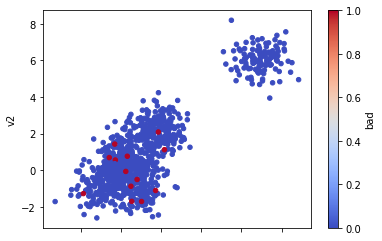

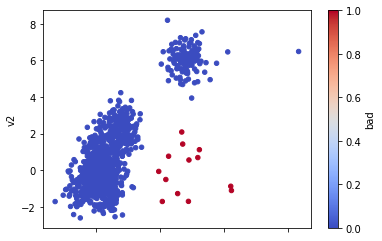

In [ ]:
# Original Data with highlighted outliers
dfblobs_baseline["bad"] = 0
bad_uids = list(results.uid.unique())

dfblobs_baseline.loc[bad_uids,"bad"] = 1
dfblobs_baseline.plot.scatter(x="v1", y="v2", c="bad", colormap="coolwarm")

# Adjusted Data with highlighted outliers
dfblobs_adjusted["bad"] = 0
dfblobs_adjusted.loc[bad_uids,"bad"] = 1
dfblobs_adjusted.plot.scatter(x="v1", y="v2", c="bad", colormap="coolwarm")